# comparison of overlay with EventWeight to Beam-On data
## when cosmic are not rescaled - i.e. POT normalization of the MC to the 4.9e19POT in the data

In [1]:
import sys; sys.path.insert(0, '../../../'); 
from ccqe_notebook_tools import * 
from mupClassification_notebooks import *
from onbeam_offbeam_notebooks import *
%matplotlib inline

versions:
{   'OffBeam': 'prod_reco_optfilter_extbnb_v12_mcc8_dev',
    'OnBeam': 'prod_reco_optfilter_bnb_v12_unblind_mcc8',
    'Overlay': 'prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2',
    'data date': '2018_05_11',
    'date': '2018_05_11',
    'overlay date': '2018_05_11'}
OffBeam_scaling: 0.706302660161 = N(on beam)/N(off beam) before SwT
f(POT): 0.0512441465374 = N(POT on beam)/N(POT MC)


In [2]:
figures_path = '/Users/erezcohen/Desktop/Projects/uBoone/write-ups/mAextraction/Figures/EventWeight/'

In [3]:
versions['overlay date'] = '2018_07_10'
versions['Overlay'] = 'prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2'

In [4]:
OverlayPairsFV, OverlaySamples = load_MCbnbDATAcosmicSamples(date=versions['overlay date'],filename=versions['Overlay']+'_'+versions['overlay date']+'_vertices')

285038 pairs from MC-BNB + cosmic DATA overlay
187286 pairs in FV
49951 are 1mu-1p, 26.7%
41680 are other pairs, 22.3%
95655 are cosmic, 51.1%
--------------------------------------------------------------
24119 are CC 1p 0pi, 12.9%


In [5]:
selected_events=pd.read_csv('/Users/erezcohen/Desktop/Projects/uBoone/write-ups/OnBeamOffBeam5e19/Figures/SelectedEvents/selected_events.csv')

# Scale the overlay to the number of POT in the data

In [7]:
summary = pd.read_csv('/Users/erezcohen/Desktop/uBoone/CCQEanalysis/csvFiles/summary/'+versions['overlay date']+'/'+versions['Overlay']+'_'+versions['overlay date']+'_summary.csv')

Nevents['OnBeam POT'] = 4.908e+19
Nevents['overlay']      = np.sum(summary.Nevents)
Nevents['overlay POT']  = np.sum(summary.POT)
Nevents['f(POT)']       = Nevents['OnBeam POT']/Nevents['overlay POT']


In [8]:
overlay_scaling = get_samples_scaling( N_total='MC(tot) x POT', debug=0, OverlaySubsamples=OverlaySamples, f_POT=Nevents['f(POT)'])
overlay_scaling

{'1mu-1p': 0.05101790352515316,
 'CC 1p 0pi': 0.051017903525153174,
 'N(Ovelay)/N(On)': 19.600962229013856,
 'cosmic': 0.05101790352515316,
 'other pairs': 0.05101790352515316}

## 2. apply the event-selection cuts

In [9]:
cuts_order  = ['no cut','Chi2Proton','MatchedFlash','length','non-collinearity','vertex activity','delta phi','Pt & delta phi']
reducedOverlay,pureffOverlay,pureffNumbers = apply_cuts_to_overlay(OverlaySamples=OverlaySamples, cuts_order=cuts_order,overlay_scaling=overlay_scaling)
print 'applied cuts to overlay'

applied cuts to overlay


In [10]:
selected_overlay=dict()
for pair_type in pair_types:
    selected_overlay[pair_type] = reducedOverlay['Pt & delta phi'][pair_type]
print len(pd.concat([selected_overlay['1mu-1p'],selected_overlay['cosmic'],selected_overlay['other pairs']])),'events in the overlay'
selected_CC1p0pi = selected_overlay['CC 1p 0pi']
print len(selected_CC1p0pi),'selected CC 1p 0pi pairs in overlay'

8978 events in the overlay
6979 selected CC 1p 0pi pairs in overlay


## 3. compare the shapes and rates after the event-selection cuts

In [11]:
mA_array = [0.40,0.70,0.80,0.95,0.99,1.00,1.10,1.15,1.35,1.71]
mA_names = ['040','070','080','095','099','100','110','115','135','171']

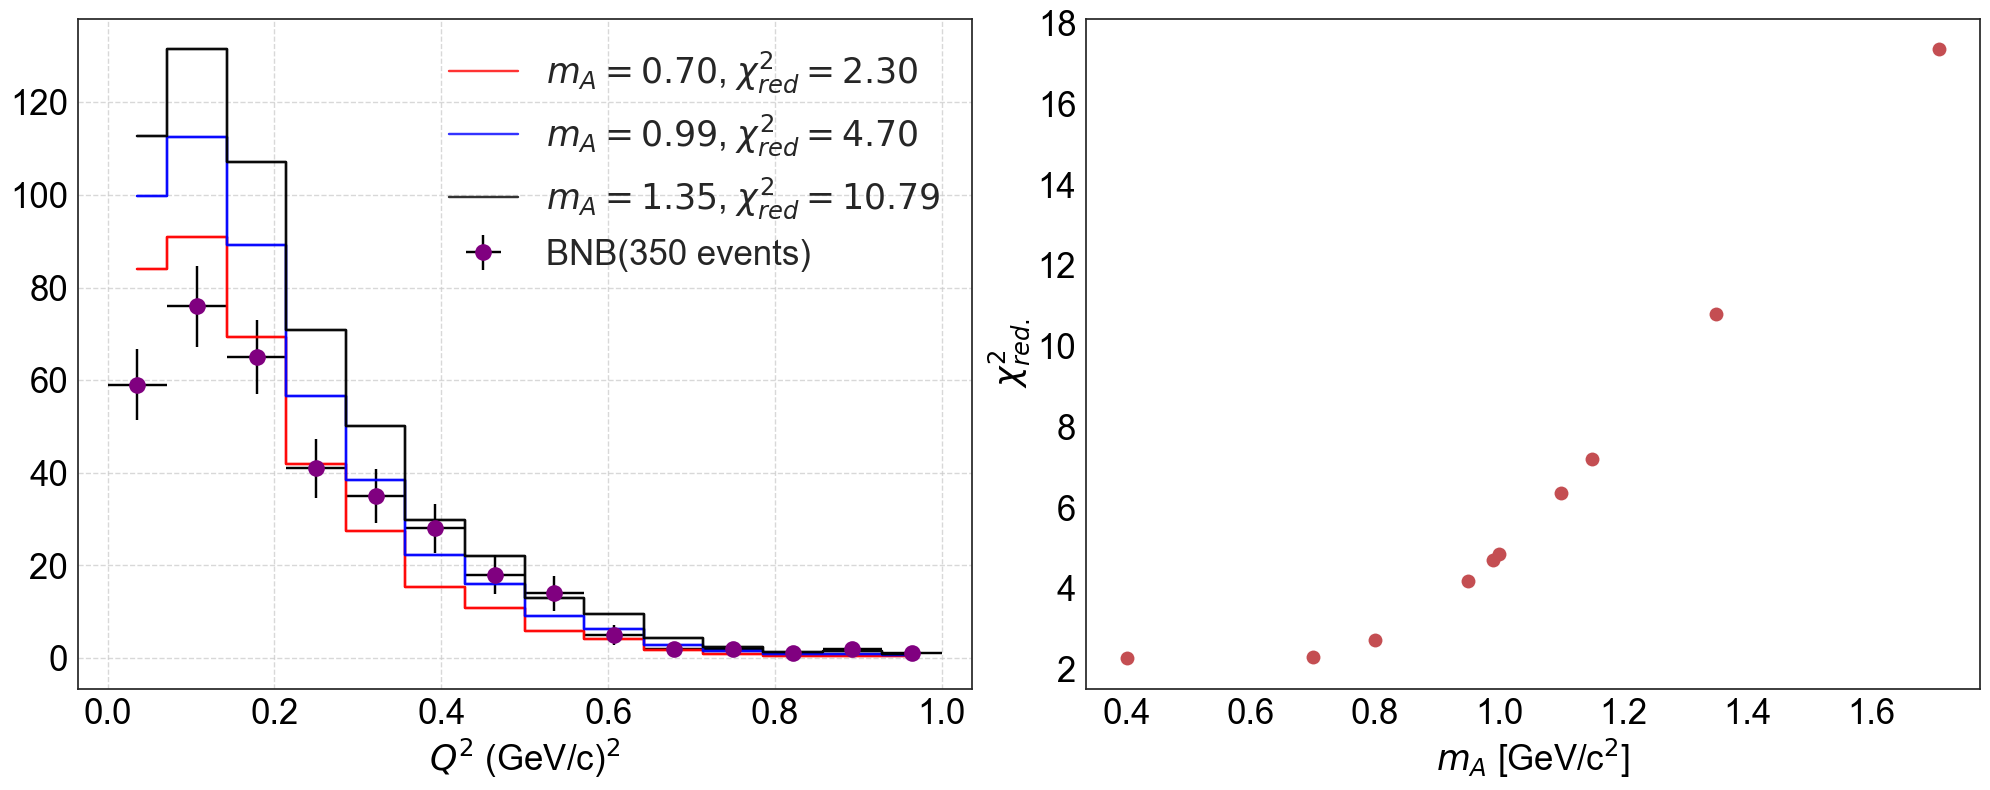

In [12]:
var,x_label = 'reco_Q2', r'$Q^2$ (GeV/c)$^2$'
bins = linspace(0,1,15); mid = 0.5*(bins[1:]+bins[:-1])
chi2_xrange = (0.,1)

fig=plt.figure(figsize=(20,8))
ax = fig.add_subplot(1,2,1)
data,mc = selected_events,selected_overlay
h_OnBeam,h_OnBeam_err=plot_OnBeam(OnBeamSample=data,color='purple',var=var, bins=bins, markersize=12, ax=ax, do_return_h=True)    
for mA,name,color in zip([0.7,0.99,1.35],['070','099','135','171'],['red','blue','black','forestgreen']):
    h_overlay,h_overlay_err=plot_stacked_MCsamples( OverlaySamples=mc
                                                   , ax=ax, overlay_scaling=overlay_scaling
                                                   , var=var
                                                   , weights_var='evwgh_mA'+name+'_Genie', bins=bins
                                                   , do_individual_histograms=False, stackColor=color
                                                   , stackLabel=None)
    if chi2_xrange is not None:
        chi2 , ndf = chi2_two_histograms( bins=bins, chi2_xrange=chi2_xrange                                     
                                         , h1=h_OnBeam , h1err=h_OnBeam_err
                                         , h2=h_overlay ,  h2err=h_overlay_err
                                         , debug=0 if mA==0.4 else 0)
        h_overlay,_=plot_stacked_MCsamples( OverlaySamples=mc
                                           , ax=ax, overlay_scaling=overlay_scaling
                                           , var=var
                                           , weights_var='evwgh_mA'+name+'_Genie'
                                           , bins=bins, do_individual_histograms=False, stackColor=color
                                           ,stackLabel='$m_A=%.2f$'%mA+', $\chi^2_{red}=%.2f$'%(chi2/ndf))
set_axes(ax,x_label,''#,ylim=(0,1.2*np.max(h_OnBeam+h_OnBeam_err))
         ,do_add_legend=True,legend_loc='upper right')

ax = fig.add_subplot(1,2,2)
chi2_red = []
for mA,name in zip(mA_array,mA_names):
    h_overlay,h_overlay_err=plot_stacked_MCsamples( OverlaySamples=mc, do_draw=False, overlay_scaling=overlay_scaling
                                                   , var=var, weights_var='evwgh_mA'+name+'_Genie', bins=bins)
    chi2 , ndf = chi2_two_histograms( bins=bins, chi2_xrange=chi2_xrange                                     
                                         , h1=h_OnBeam , h1err=h_OnBeam_err
                                         , h2=h_overlay ,  h2err=h_overlay_err
                                         , debug=0 if mA==0.4 else 0)
    chi2_red.append(chi2/ndf)
plt.errorbar(mA_array,chi2_red,fmt='ro',markersize=10)
set_axes(ax,r'$m_A$ [GeV/c$^2$]',r'$\chi^2_{red.}$')
plt.tight_layout()

# What is the contribution of MEC to the events-distribution? 

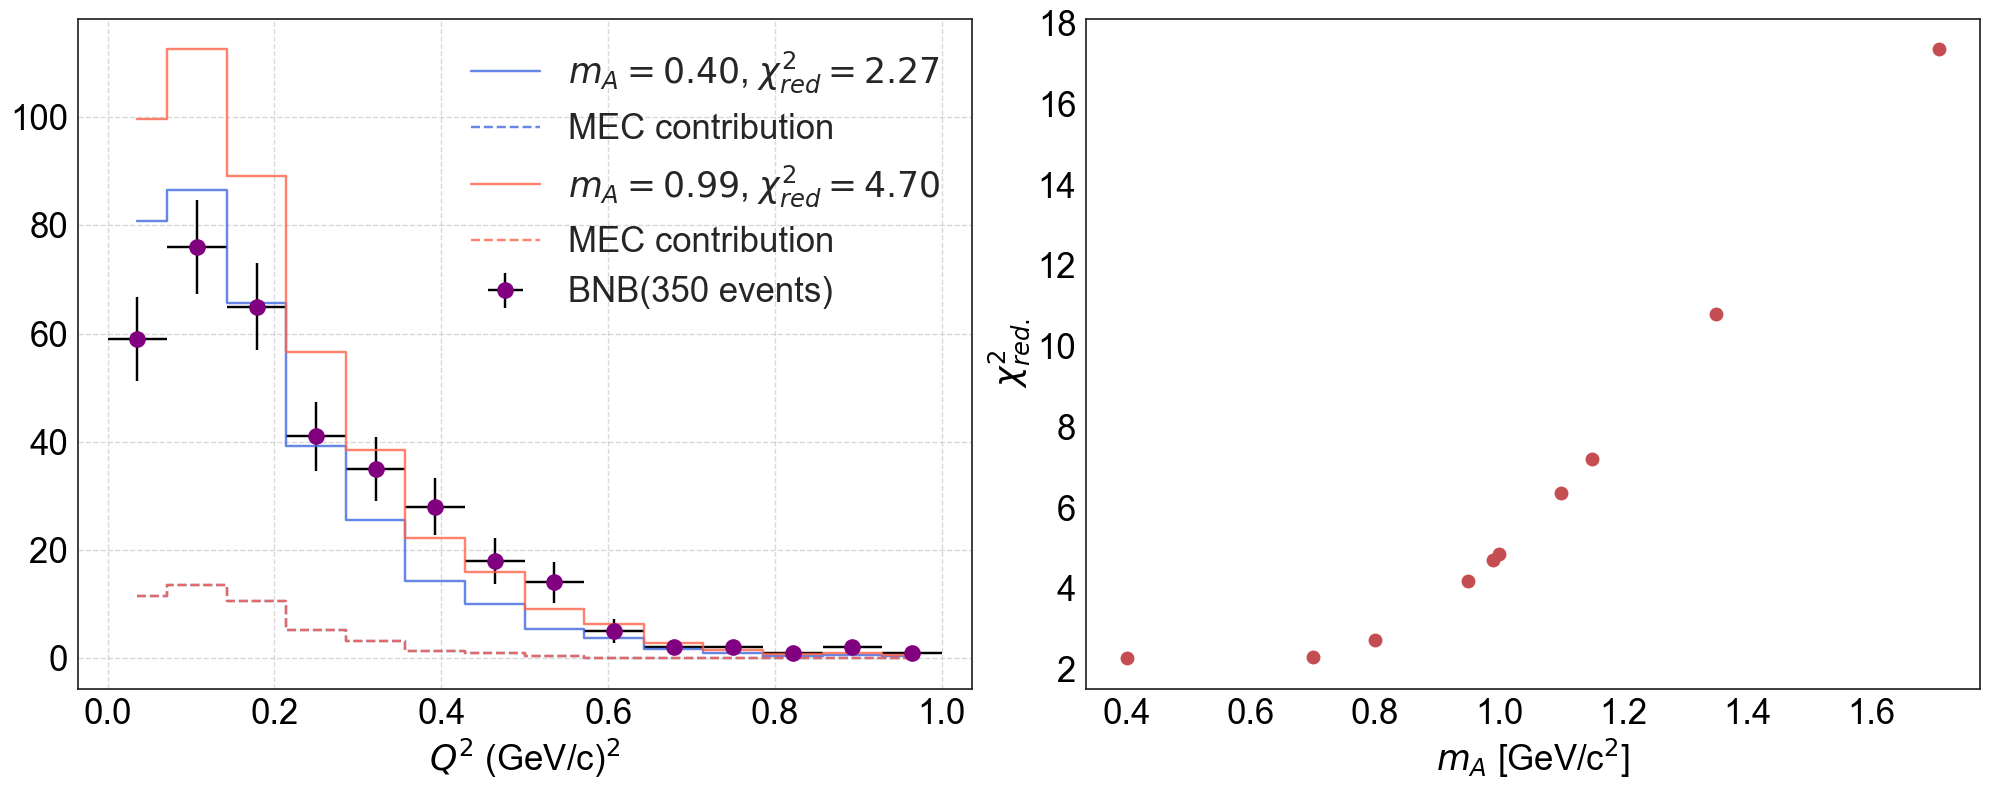

In [32]:
var,x_label = 'reco_Q2', r'$Q^2$ (GeV/c)$^2$'
bins = linspace(0,1,15); mid = 0.5*(bins[1:]+bins[:-1])
chi2_xrange = (0.,1)

fig=plt.figure(figsize=(20,8))
ax = fig.add_subplot(1,2,1)
data,mc = selected_events,selected_overlay
h_OnBeam,h_OnBeam_err=plot_OnBeam(OnBeamSample=data,color='purple',var=var, bins=bins, markersize=12, ax=ax, do_return_h=True)    

for mA,name,color in zip([0.4,0.99],['040','099'],['royalblue','tomato']):
    h_overlay,h_overlay_err=plot_stacked_MCsamples( OverlaySamples=mc,do_draw=False, overlay_scaling=overlay_scaling
                                                   , var=var, weights_var='evwgh_mA'+name+'_Genie', bins=bins)
    if chi2_xrange is not None:
        chi2 , ndf = chi2_two_histograms( bins=bins, chi2_xrange=chi2_xrange                                     
                                         , h1=h_OnBeam , h1err=h_OnBeam_err
                                         , h2=h_overlay ,  h2err=h_overlay_err
                                         , debug=0 if mA==0.4 else 0)
        h_overlay,_=plot_stacked_MCsamples( OverlaySamples=mc, var=var,do_add_MEC_contribution=True
                                           , ax=ax, overlay_scaling=overlay_scaling
                                           , weights_var='evwgh_mA'+name+'_Genie'
                                           , bins=bins, do_individual_histograms=False, stackColor=color
                                           ,stackLabel='$m_A=%.2f$'%mA+', $\chi^2_{red}=%.2f$'%(chi2/ndf))
set_axes(ax,x_label,'',do_add_legend=True,legend_loc='upper right')

ax = fig.add_subplot(1,2,2)
chi2_red = []
for mA,name in zip(mA_array,mA_names):
    h_overlay,h_overlay_err=plot_stacked_MCsamples( OverlaySamples=mc, do_draw=False, overlay_scaling=overlay_scaling
                                                   , var=var, weights_var='evwgh_mA'+name+'_Genie', bins=bins)
    chi2 , ndf = chi2_two_histograms( bins=bins, chi2_xrange=chi2_xrange                                     
                                         , h1=h_OnBeam , h1err=h_OnBeam_err
                                         , h2=h_overlay ,  h2err=h_overlay_err
                                         , debug=0 if mA==0.4 else 0)
    chi2_red.append(chi2/ndf)
plt.errorbar(mA_array,chi2_red,fmt='ro',markersize=10)
set_axes(ax,r'$m_A$ [GeV/c$^2$]',r'$\chi^2_{red.}$')
plt.tight_layout()

# compare as a function of $p_p$

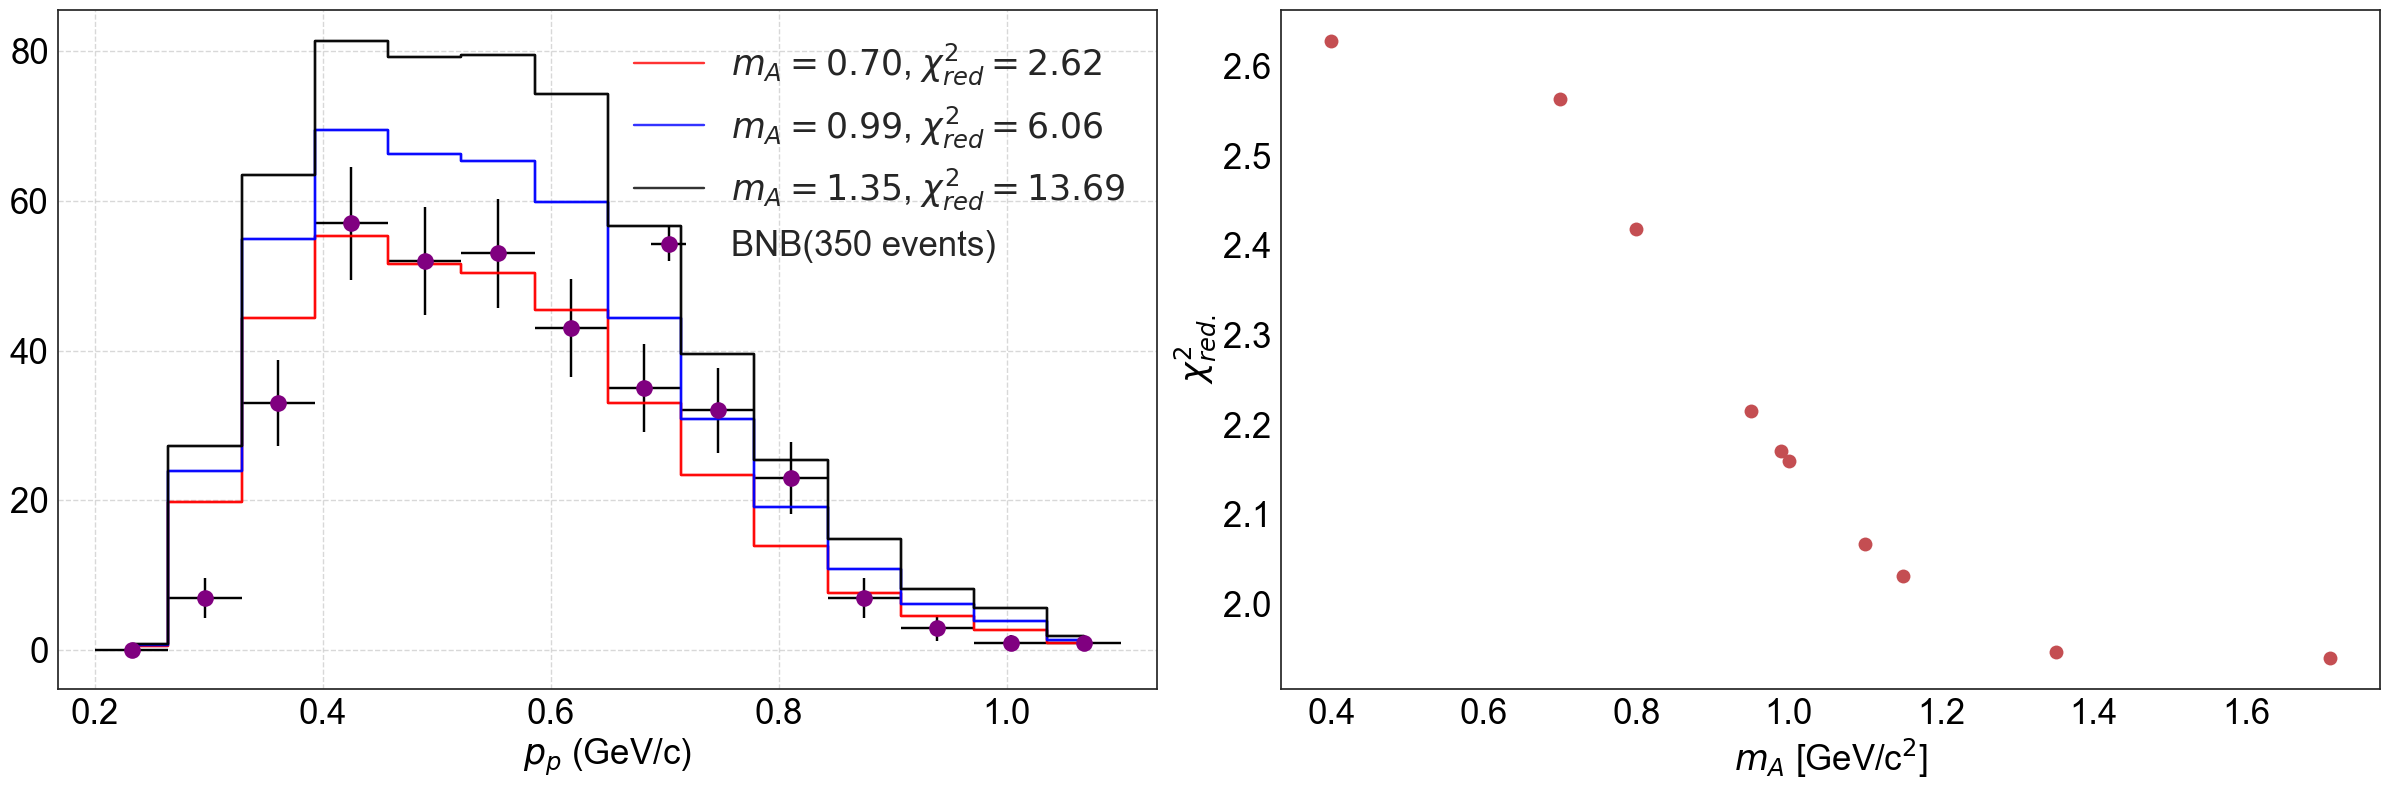

In [13]:
var,x_label = 'reco_Pp', r'$p_p$ (GeV/c)'
bins = linspace(0.2,1.1,15); mid = 0.5*(bins[1:]+bins[:-1])
chi2_xrange = (0.2,1.1)

fig=plt.figure(figsize=(24,8))
ax = fig.add_subplot(1,2,1)
data,mc = selected_events,selected_overlay
h_OnBeam,h_OnBeam_err=plot_OnBeam(OnBeamSample=data,color='purple',var=var, bins=bins, markersize=12, ax=ax, do_return_h=True)    
for mA,name,color in zip([0.7,0.99,1.35],['070','099','135','171'],['red','blue','black','forestgreen']):
    h_overlay,h_overlay_err=plot_stacked_MCsamples( OverlaySamples=mc
                                                   , ax=ax, overlay_scaling=overlay_scaling
                                                   , var=var
                                                   , weights_var='evwgh_mA'+name+'_Genie', bins=bins
                                                   , do_individual_histograms=False, stackColor=color
                                                   , stackLabel=None)
    if chi2_xrange is not None:
        chi2 , ndf = chi2_two_histograms( bins=bins, chi2_xrange=chi2_xrange                                     
                                         , h1=h_OnBeam , h1err=h_OnBeam_err
                                         , h2=h_overlay ,  h2err=h_overlay_err
                                         , debug=0 if mA==0.4 else 0)
        h_overlay,_=plot_stacked_MCsamples( OverlaySamples=mc
                                           , ax=ax, overlay_scaling=overlay_scaling
                                           , var=var
                                           , weights_var='evwgh_mA'+name+'_Genie'
                                           , bins=bins, do_individual_histograms=False, stackColor=color
                                           ,stackLabel='$m_A=%.2f$'%mA+', $\chi^2_{red}=%.2f$'%(chi2/ndf))
set_axes(ax,x_label,'',do_add_legend=True,legend_loc='upper right')

ax = fig.add_subplot(1,2,2)
chi2_red = []
for mA,name in zip(mA_array,mA_names):
    h_overlay,h_overlay_err=plot_stacked_MCsamples( OverlaySamples=mc
                                                   , norm=len(data), do_draw=False
                                                   , overlay_scaling=overlay_scaling
                                                   , var=var, weights_var='evwgh_mA'+name+'_Genie', bins=bins)
    chi2 , ndf = chi2_two_histograms( bins=bins, chi2_xrange=chi2_xrange                                     
                                         , h1=h_OnBeam , h1err=h_OnBeam_err
                                         , h2=h_overlay ,  h2err=h_overlay_err
                                         , debug=0 if mA==0.4 else 0)
    chi2_red.append(chi2/ndf)
plt.errorbar(mA_array,chi2_red,fmt='ro',markersize=10)
set_axes(ax,r'$m_A$ [GeV/c$^2$]',r'$\chi^2_{red.}$')
plt.tight_layout()